In [1]:
import matplotlib.pyplot as plt

import initialconditions as ic

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

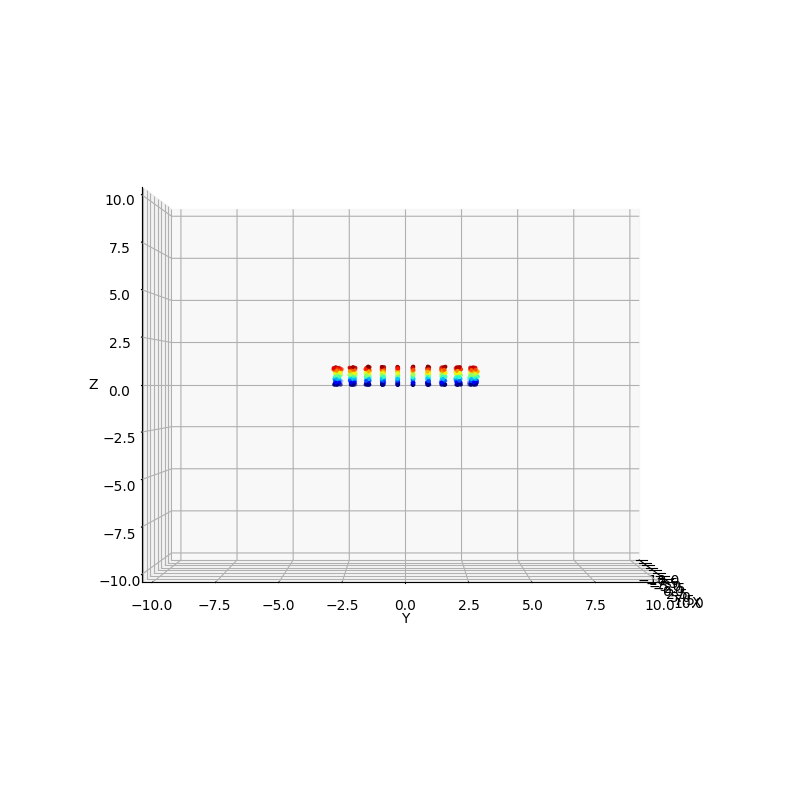

In [2]:
# Define the parameters of the system

N = 1000 # Number of seeds
box = [-4, -4, 0, 4, 4, 1] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = True # Set the periodicity of X
per_y = True # Set the periodicity of Y
per_z = False # Set the periodicity of Z
a = 8 # Set replication parameter
tf = 0.03 # Final time
Ndt = 3 # Number of timesteps

#Initialize initial condition
Z = ic.create_initial(N, -3, -3, 0, 3, 3, 1, 'lattice') #Initial seed positions

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 0, azim = 0)

plt.show()

In [3]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, per_x, per_y, per_z, a) #Solve and save the solution

0
1


: 

: 

In [ ]:
ani.point_animator('./SG_data.npz', 'C', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'C', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.cell_animator('./SG_data.npz', box) #Animate the cells

In [ ]:
from pysdot import OptimalTransport
import numpy as np
import pyvista as pv
import weightguess as wg
import optimaltransportsolver as ots

nb_diracs = 216

masses =  64 * np.ones( nb_diracs ) / nb_diracs

domain = ots.make_domain(box, per_x, per_y, per_z, a)

psi = np.zeros(shape = (nb_diracs,))

# we have to specify that dirac masses because by default, sdot takes ones * measure( domain ) / nb_diracs
# and that's not what we want in this case
w0 = wg.rescale_weights(box, Z, psi, per_x, per_y, per_z)[0]
ot = OptimalTransport( positions = Z, domain = domain, masses = masses, weights = w0 )

# first arg of add_replication is a translation
for x in [ -a, 0, a ]:
    for y in [ -a, 0, a ]:
        if x or y:
            ot.pd.add_replication( [ x, y, 0 ] )

ot.adjust_weights()

filename = 'pb.vtk'
ot.pd.display_vtk( 'pb.vtk' )

# Mass of cells
vols=ot.pd.integrals()
print(sum(vols))

# Read the data
grid=pv.read(filename)

# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_vols = vols[grid.cell_data['num'].astype(int)]
grid.cell_data['vols']=cell_vols

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = True, off_screen=False)
plotter.add_mesh(grid)

# Render the frame
plotter.show()
